<h1>Projet IARN</h1>
<h2>Theme: <b>Classification des emails</b></h2>
<h3>Etudiants:</h3>

- SI MOHAMMED Cherif 181831018892
- HAMMAZ Massinissa 181831015896
- SADOUDI Brahim 181831013058
- SADADOU Mohamed 181833012802

# Sommaire

1. [Librairie](#lib)<br/><br/>

2. [Emplacements des donnees](#path)<br/><br/>

3. [Fonctions](#fun)
    1. [Fonction de chargement des donnees](#load)
    2. [Fonctions de pre-processing](#prepro)
    3. [Fonctions de Construction du Vocabulaire](#vocabFun)
    4. [Fonctions d'extraction des caracteristiques](#caractFun)<br/><br/>

4. [Applications](#app)
    1. [Chargement des donnees](#donnees)
    2. [Data pre-processing](#datapro)
    3. [Construction du vocabulaire](#vocabconst)
    4. [TrainSet & TestSet](#tsts)<br/><br/>

5. [Visualisation](#vis)
    1. [Visualisation des donnees](#datavis)
    2. [Visualisation du vocabulaire](#vocabvis)<br/><br/>

6. [Classification](#classification)
    1. [LogisticRegression](#lr)
    2. [RandomForestClassifier](#rf)
    3. [Gaussian Naive Bayes](#gnb)
    4. [SVM](#svm)
    5. [Reseau de neurones](#rn)

## 1. importation des librairies
<a id="lib"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import string
import email
import seaborn as sns
from bs4 import BeautifulSoup
from html.parser import HTMLParser 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.model_selection import cross_val_predict

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD

#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve

## 2. Dataset Path
<a id="path"></a>

In [2]:
#On a choisi ces 5 dossiers
#2 Contenant des email non Spam
#3 pour les fichiers Spam

easy_ham = "20021010_easy_ham/easy_ham/"
hard_ham = "20021010_hard_ham/hard_ham/"
spam1_db = "20021010_spam/spam/"
spam2_db = "20050311_spam_2/spam_2/"
spam3_db = "20030228_spam/spam/"


# 3. Fonctions
<a id="fun"></a>

## 3.1. Chargement des donnees
<a id="load"></a>

In [3]:
def load_data(path):
    
    data = []
    #charger les fichiers txt du dataset
    files = os.listdir(path)
    print(f"Chargment du dataset {path} : {len(files)} e_mail")
    for file in files:
        
        #lire le fichier txt
        txt_file = open(path+file, encoding= "ISO-8859-1")
        #lire le contenu
        txt = txt_file.read()
        
        #ajouter le contenu du fichier dans le tableau data
        data.append(txt)
        txt_file.close()
    return data


## 3.2. Data-processing
<a id="prepro"></a>

In [4]:
def extractBody(txt_email):
    
    #Extraire le code de l'email avec le module email
    b = email.message_from_string(txt_email)
    
    body = ""

    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # get body of email
                break
    else:
        body = b.get_payload(decode=True)

    return body

def dataPreprocessing(data):
    radical = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    dataprocessed = []
    
    for email in data:
        
        #get email body
        body = extractBody(email)
        
        #get text from body (HTML/text)
        soup = BeautifulSoup(body, "html.parser")
        
        #convertire l'intergrite de l'email en minuscules
        text = soup.get_text().lower()
        
        #supprimer les balises HTML
        text = re.sub('<.*?>', ' ', text )
        
        ##supprimer Liens  
        #text = re.sub(r'www.*', ' httpaddr ', text)
        text = re.sub(r'(https|http|www.)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' httpaddr ', text)
        
        #remove email addresses
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ' emailaddress ', text) 
        
        #suppriemer les nombres
        text = re.sub('[0-9]+'," nombre ",text)
        
        #supprimer dollar
        text = re.sub("\$"," dollar ",text)
        
        # remove punctuation
        for c in string.punctuation:
            text = text.replace(c,' ')
        
        #radicalisation  des mots avec NLTK
        # supprimer les stop words
        stop_words = stopwords.words('english')
        words_list = [w for w in text.split() if w not in stop_words] 
        #Lemmatisation
        words_list = [lemmatizer.lemmatize(w) for w in words_list] 
        #Radicalisation
        words_list = [radical.stem(word) for word in words_list] 
        
        if len(words_list) != 0: #supprimer les email vide 
        
            dataprocessed.append(' '.join(words_list))

    return dataprocessed 


## 3.3. Construction du vocabulaire 
<a id="vocabFun"></a>

In [5]:
def formationVocabulaire(data, k = 10,name_file = "vocab.txt"):
    
    file = open(name_file,'w') #cree un fichier vocab
    
    vocab = {}
    prob = []
    vocab_a_utilise = []
    
    for d_txt in data:
        list_ = [d_txt]
        #calcule le nombre d'occurence de chaque mots avec CountVectorizer
        coun_vect = CountVectorizer(stop_words='english')
        try:
            
            count_array = coun_vect.fit_transform(list_).toarray()
            feature = coun_vect.get_feature_names() 
            result = list(map(lambda row:dict(zip(feature,row)),count_array))[0]
        
        
            for rs in result.keys():
                if rs in vocab.keys():
                    vocab[rs] += result.get(rs)
                else:
                    vocab[rs] = result.get(rs)
        except:
            print("erreur: ",len(d_txt))
        
        #CountVectorize: calcule pour chaque mots dans une chaine de caractere le nombre d'occurence
        #return une liste de mots et une liste des occurrence
        

    for word in vocab.keys():
        #Ajouter au fichier et au vocabulaire a utilisé que les mots repete plus de k fois
        if vocab.get(word) >= k:
            file.write(f"{word} {vocab.get(word)}\n")
            vocab_a_utilise.append(word)
    
    return vocab_a_utilise



## 3.4. Extraction des catacteristiques
<a id="caractFun"></a>

In [6]:
def MapEmail(email, vocab):
    
    listword = email.split()
    index = []
    for word in listword:
        if word in vocab:
            index.append(word)
    return index

def BinarieRepres(email_word_list, vocab):
    #Repraisentation Binaire 
    features_vec = np.zeros(len(vocab))
    index = 0
    for word in email_word_list:
        if word in vocab:
            index = vocab.index(word)
            features_vec[index] = 1
        
    return features_vec

def NbOccurenceRepres(email_word_list, vocab):
    #Representation avec nbr d'occurence 
    features_vec = np.zeros(len(vocab))
    index = 0
    for word in email_word_list:
        if word in vocab:
            index = vocab.index(word)
            features_vec[index] = email_word_list.count(word)
        
    return features_vec

# 4. Pre-Traitement
<a id="app"></a>

## 4.1. Chargement des donnees
<a id="donnees"></a>

In [7]:
data_spam = load_data(spam1_db)[1:] + load_data(spam2_db) + load_data(spam3_db)#Chargement des email Spam
data_ham = load_data(easy_ham) + load_data(hard_ham) #Chargement des email non Spam
print("Taille du dataset des spam: ",len(data_spam))
print("Taille du dataset des Ham: ",len(data_ham))

Chargment du dataset 20021010_spam/spam/ : 501 e_mail
Chargment du dataset 20050311_spam_2/spam_2/ : 1397 e_mail
Chargment du dataset 20030228_spam/spam/ : 501 e_mail
Chargment du dataset 20021010_easy_ham/easy_ham/ : 2551 e_mail
Chargment du dataset 20021010_hard_ham/hard_ham/ : 250 e_mail
Taille du dataset des spam:  2398
Taille du dataset des Ham:  2801


## 4.2. Data pre-processing
<a id="datapro"></a>

In [8]:
data_spam_E1 = dataPreprocessing(data_spam) #Traitement des Spam 
data_ham_E1 = dataPreprocessing(data_ham) #Tratement des Nom spam

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
/home/cherif/anaconda3/envs/myenv2/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/cherif/anaconda3/envs/myenv2/lib/python3.7/site-packages/bs4/__init__.py:408: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT

## 4.3. Construction du vocabulaire
<a id="vocabconst"></a>

In [9]:
vocab = formationVocabulaire((data_spam_E1), k = 5) 
#Formation du vocabulaire en utilisent les email spam pour extraire
#les caracteristique d'un email Spam 
print("Taille du vocabulaire: ",len(vocab))
print(vocab)

/home/cherif/anaconda3/envs/myenv2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Taille du vocabulaire:  6235
['access', 'archiv', 'articl', 'assist', 'associ', 'benefit', 'best', 'break', 'colleagu', 'collect', 'com', 'comment', 'contact', 'contain', 'current', 'daili', 'dear', 'depart', 'ein', 'email', 'emailaddress', 'exchang', 'feel', 'forward', 'free', 'headlin', 'hourli', 'httpaddr', 'import', 'inform', 'iraq', 'list', 'madam', 'mail', 'manag', 'mani', 'market', 'need', 'news', 'nombr', 'offer', 'partial', 'person', 'petr', 'pleas', 'question', 'rate', 'regard', 'remov', 'repli', 'servic', 'sign', 'simpli', 'sir', 'stanek', 'subscrib', 'subscript', 'today', 'trial', 'updat', 'write', 'www', 'ad', 'bodi', 'click', 'compani', 'correspond', 'direct', 'em', 'includ', 'line', 'member', 'messag', 'movi', 'netnoteinc', 'product', 'receiv', 'sendgreatoff', 'sgo', 'subject', 'ticket', 'unsubscrib', 'approv', 'auto', 'card', 'credit', 'day', 'event', 'fast', 'group', 'insur', 'irish', 'linux', 'llc', 'loan', 'maintain', 'opt', 'pay', 'prizemama', 'publish', 'report', '

## 4.4. TrainSet & TestSet
<a id="tsts"></a>

In [10]:
#Creation des entree pour l'entrainement 
y = np.array(len(data_spam_E1)*[0] + len(data_ham_E1)*[1])

all_data = data_spam_E1 + data_ham_E1

dataa = [] 
i =0
for data in all_data:
    
    vec = BinarieRepres(data.split(),vocab)
    
    dataa.append(vec)
    i+=1

x = np.array(dataa)
print("Echantion:")
print(x[:5])

Echantion:
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.2)
#Creation du data set d'entrainement et le test

# 5. Visualisation des donnees
<a id="vis"></a>

## 5.1. Visualisation des data set
<a id="datavis"></a>

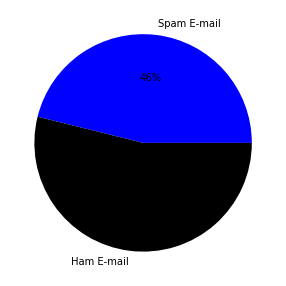

In [12]:
#visualisation du pourcetange de chaque categorie de mail

data = [len(data_spam)/len(data_ham+data_spam), len(data_ham)/len(data_spam+data_ham)]
labels = [ 'Spam E-mail','Ham E-mail']
colors = ['blue', 'black']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

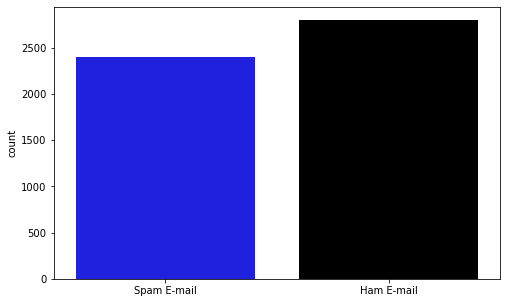

In [13]:
plt.figure(figsize=(8, 5))
colors = ['blue','black']
sns.countplot(x = ['Spam E-mail']*len(data_spam) + ['Ham E-mail']*len(data_ham), palette=colors)
plt.show()

## 5.2. Nuage de mots du vocabulaire
<a id="vocabvis"></a>

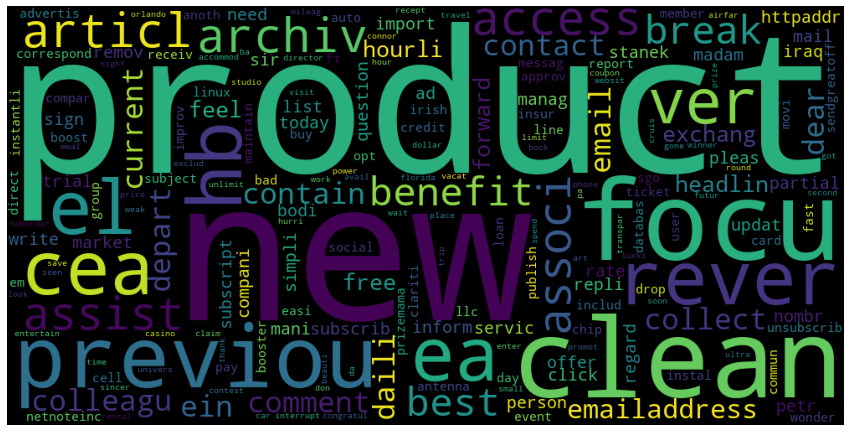

In [14]:
def plot_Vocabu(text_list):
    unique_string=(" ").join(text_list)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
#Creation d'un nuage de mots a partire des mots du vocabulaire
plot_Vocabu(vocab)

# 6. Classification
<a id="classification"></a>

## 6.1. LogisticRegression
<a id="lr"></a>

### Training & test

In [15]:
#1er modele: Regression logistique
model1 = LogisticRegression(random_state=0) #Creation du modele
train_score = model1.fit(X_train, y_train) #Entrainement 
print("Train Score :", train_score) 

Train Score : LogisticRegression(random_state=0)


In [16]:
test_score = model1.score(X_test, y_test) #test
print("Le test score: ",test_score)

Le test score:  0.9783677482792527


### Courbe d'apprentissage

In [17]:

#tracage de la courbe d'entrainement pour voir l'evaluation du modele en fonction du nombre de donnee
n, train_score, val_score = learning_curve(LogisticRegression(random_state=0) , X_train, y_train,
                                         train_sizes= np.linspace(0.1,1.0,10),cv=5)

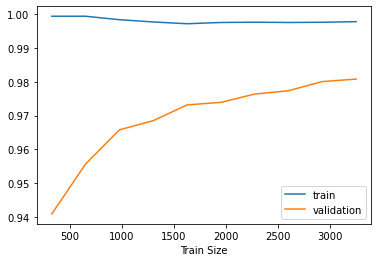

In [18]:
plt.plot(n, train_score.mean(axis=1),label="train")
plt.plot(n, val_score.mean(axis=1),label="validation")
plt.xlabel("Train Size")
plt.legend()

### Evaluation


In [19]:
prediction = model1.predict(X_test) #Les prediction

#### Rappel

In [20]:
# Calcule du Rappel
rappel_ = recall_score(y_test,prediction,average='macro')
print(f"Le rappel: {rappel_}")

Le rappel: 0.9781435604876524


#### Precision

In [21]:
# Calcule de la Precision
precision_ = precision_score(y_test,prediction,average='macro')
print(f"La precision: {precision_}")

La precision: 0.9781435604876524


#### Matrice de confusion

In [22]:
mat_confu = confusion_matrix(y_test, prediction) #Matrice de confusion

Text(51.0, 0.5, 'Valeurs réels ')

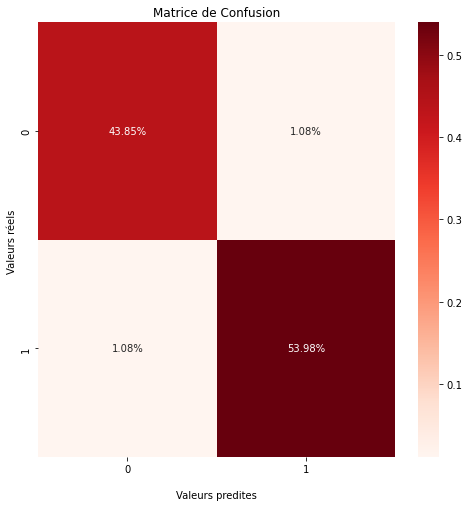

In [23]:
plt.figure(figsize=(8,8))   
ax = sns.heatmap(mat_confu/np.sum(mat_confu), fmt='.2%', annot=True, cmap='Reds')
ax.set_title('Matrice de Confusion')
ax.set_xlabel('\nValeurs predites')
ax.set_ylabel('Valeurs réels ')

#### Courbe ROC

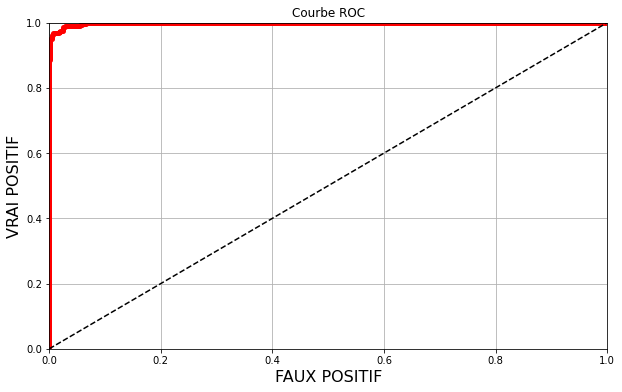

In [24]:
y_scores = model1.predict_proba(X_test)
fp1, tp1, thresholds = roc_curve(y_test, y_scores[:,1])

plt.figure(figsize=(10, 6))
plt.plot(fp1, tp1, linewidth=5, color='r')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('FAUX POSITIF', fontsize=16)
plt.ylabel('VRAI POSITIF', fontsize=16)
plt.grid(True)
plt.title("Courbe ROC")
plt.show()

## 6.2. RandomForestClassifier
<a id="rf"></a>

### Training & Test

In [25]:
#Le 2eme modele RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=1000) #Creation du modele
train_score2 = model2.fit(X_train, y_train) #Entrainement
print("Train Score :", train_score2)

Train Score : RandomForestClassifier(n_estimators=1000)


In [26]:
test_score2 = model2.score(X_test, y_test) #test
print("Le test score: ",test_score2)

Le test score:  0.976401179941003


### Courbe d'apprentissage

In [27]:
#n2, train_score2, val_score2 = learning_curve(RandomForestClassifier(n_estimators=1000) , X_train, y_train,
#                                        train_sizes= np.linspace(0.1,1.0,5),cv=5)

In [28]:
#plt.plot(n2, train_score2.mean(axis=1),label="train")
#plt.plot(n2, val_score2.mean(axis=1),label="validation")
#plt.xlabel("Train Size")
#plt.legend()

### Evaluation

In [29]:
prediction2 = model2.predict(X_test) #Predire 

#### Rappel

In [30]:
#Calcule du Rappel
rappel_2 = recall_score(y_test,prediction2,average='macro')
print(f"Le rappel: {rappel_2}")

Le rappel: 0.9775652547671148


#### Precision

In [31]:
#calcule de la Precision
precision_2 = precision_score(y_test,prediction2,average='macro')
print(f"La precision: {precision_2}")

La precision: 0.975251394041203


#### Matrice de confusion

In [32]:
mat_confu2 = confusion_matrix(y_test, prediction2) #Matrice de confusion

Text(51.0, 0.5, 'Valeurs réels ')

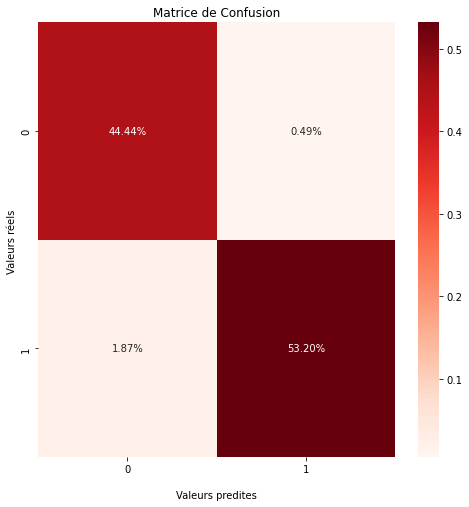

In [33]:
plt.figure(figsize=(8,8))   
ax2 = sns.heatmap(mat_confu2/np.sum(mat_confu2), fmt='.2%', annot=True, cmap='Reds')
ax2.set_title('Matrice de Confusion')
ax2.set_xlabel('\nValeurs predites')
ax2.set_ylabel('Valeurs réels ')

#### Courbe ROC

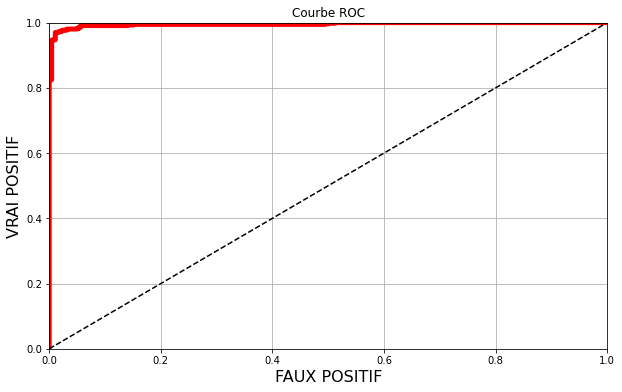

In [34]:

y_scores2 = model2.predict_proba(X_test)
fp2, tp2, t2 = roc_curve(y_test, y_scores2[:,1])

plt.figure(figsize=(10, 6))
plt.plot(fp2, tp2, linewidth=5, color='r')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('FAUX POSITIF', fontsize=16)
plt.ylabel('VRAI POSITIF', fontsize=16)
plt.grid(True)
plt.title("Courbe ROC")
plt.show()

## 6.3. Gaussian Naive Bayes
<a id="gnb"></a>

### Train & Test

In [35]:
#3eme modele loi de gausse
model3 = GaussianNB()
train_score3 = model3.fit(X_train, y_train)
print("Train Score :", train_score3)

Train Score : GaussianNB()


In [36]:
test_score3 = model3.score(X_test, y_test)
print("Le test score: ",test_score3)

Le test score:  0.8289085545722714


### Learning curve

In [37]:
n3, train_score3, val_score3 = learning_curve(GaussianNB() , X_train, y_train,
                                         train_sizes= np.linspace(0.1,1.0,10),cv=5)

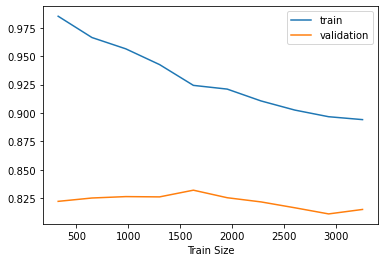

In [38]:
plt.plot(n3, train_score3.mean(axis=1),label="train")
plt.plot(n3, val_score3.mean(axis=1),label="validation")
plt.xlabel("Train Size")
plt.legend()

### Evaluation

In [39]:
prediction3 = model3.predict(X_test) #Prediction

#### Rappel

In [40]:
# Rappel
rappel_3 = recall_score(y_test,prediction3,average='macro')
print(f"Le rappel: {rappel_3}")

Le rappel: 0.8204946858393247


#### Precision

In [41]:
#Precision
precision_3 = precision_score(y_test,prediction3,average='macro')
print(f"La precision: {precision_3}")

La precision: 0.8350996461926901


#### Matrice de confusion

In [42]:
mat_confu3 = confusion_matrix(y_test, prediction3) #Matrice de confusion

Text(51.0, 0.5, 'Valeurs réels ')

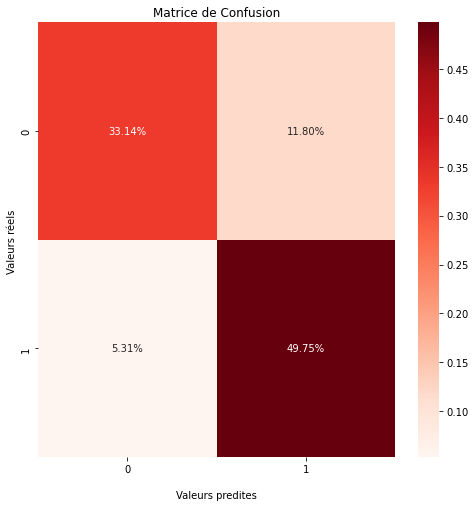

In [43]:
plt.figure(figsize=(8,8))   
ax3 = sns.heatmap(mat_confu3/np.sum(mat_confu3), fmt='.2%', annot=True, cmap='Reds')
ax3.set_title('Matrice de Confusion')
ax3.set_xlabel('\nValeurs predites')
ax3.set_ylabel('Valeurs réels ')

#### Courbe ROC

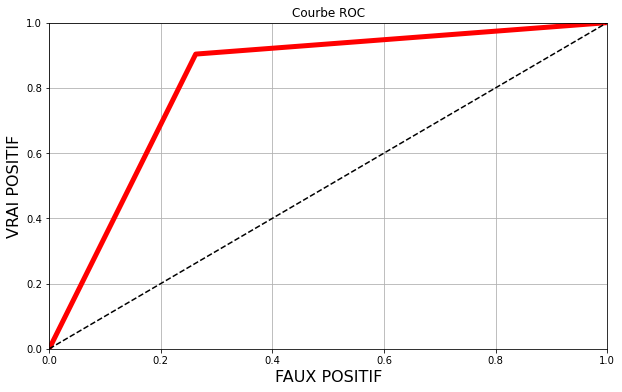

In [45]:
y_scores3 = model3.predict_proba(X_test)
fp3, tp3, t3 = roc_curve(y_test, y_scores3[:,1])

plt.figure(figsize=(10, 6))
plt.plot(fp3, tp3, linewidth=5, color='r')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('FAUX POSITIF', fontsize=16)
plt.ylabel('VRAI POSITIF', fontsize=16)
plt.grid(True)
plt.title("Courbe ROC")
plt.show()

## 6.4. SVM
<a id="svm"></a>

### Train & Test

In [46]:
model4 = SVC(random_state=42)
train_score4 = model4.fit(X_train, y_train)
print("Train Score :", train_score4)
#svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)

Train Score : SVC(random_state=42)


In [47]:
test_score4 = model4.score(X_test, y_test)
print("Le test score: ",test_score4)

Le test score:  0.9695181907571289


### Courbe d'apprentissage

In [48]:
#n4, train_score4, val_score4 = learning_curve(SVC(random_state=42) , X_train, y_train,
#                                         train_sizes= np.linspace(0.1,1.0,10),cv=5)

In [49]:
#plt.plot(n4, train_score4.mean(axis=1),label="train")
#plt.plot(n4, val_score4.mean(axis=1),label="validation")
#plt.xlabel("Train Size")
#plt.legend()

### Evaluation

In [50]:
prediction4 = model4.predict(X_test)

#### Rappel

In [51]:
# Rappel
rappel_4 = recall_score(y_test,prediction4,average='macro')
print(f"Le rappel: {rappel_4}")

Le rappel: 0.9678942638324476


#### Precision

In [52]:
#Precision
precision_4 = precision_score(y_test,prediction4,average='macro')
print(f"La precision: {precision_4}")

La precision: 0.9706676571859818


#### Matrice de confusion

In [53]:
mat_confu4 = confusion_matrix(y_test, prediction4)

Text(51.0, 0.5, 'Valeurs réels ')

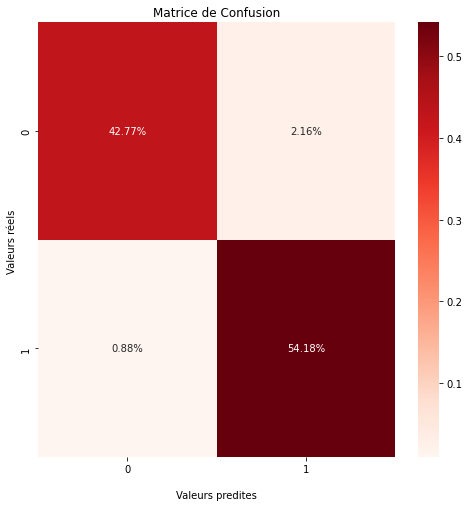

In [54]:
plt.figure(figsize=(8,8))   
ax4 = sns.heatmap(mat_confu4/np.sum(mat_confu4), fmt='.2%', annot=True, cmap='Reds')
ax4.set_title('Matrice de Confusion')
ax4.set_xlabel('\nValeurs predites')
ax4.set_ylabel('Valeurs réels ')

## 6.5. Reseau de neurones
<a id="rn"></a>

In [56]:
def BuildModel(taille):
    
    modelInput = Input(shape=taille) #input layer
    
    couche = Dense(100, activation="sigmoid")(modelInput)# 1st hidden layer
    
    couche = Dense(100, activation="sigmoid")(couche)# 2nd hidden layer
    
    couche = Dense(100, activation="sigmoid")(couche)# 3rd hidden layer
    
    output = Dense(2, activation="sigmoid")(couche) #output layer
    
    return Model(name="Classifier", inputs = [modelInput], outputs=output)
def BuildModel2(taille):
    
    model = Sequential()
    
    model.add(Input(shape=taille)) #input layer
    
    model.add(Dense(100, activation="sigmoid"))# 1st hidden layer
    
    model.add(Dense(100, activation="sigmoid"))# 2nd hidden layer
    
    model.add(Dense(100, activation="sigmoid"))# 3rd hidden layer
    
    model.add(Dense(1, activation="sigmoid")) #output layer
    return model
   
    
print(X_train.shape[1])

model5 = BuildModel2(X_train.shape[1])
model5.summary()

model5.compile(optimizer=SGD(0.001), loss='binary_crossentropy', metrics=["accuracy"])

model5.fit(x = X_train,y = y_train, validation_split=0.3,batch_size=500,epochs=50)


6235
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               623600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 643,901
Trainable params: 643,901
Non-trainable params: 0
_________________________________________________________________


2022-06-18 22:21:02.484695: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-06-18 22:21:02.509809: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1800000000 Hz
2022-06-18 22:21:02.510342: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f27e10baf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-18 22:21:02.510369: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-18 22:21:02.510502: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Train on 2844 samples, validate on 1220 samples
Epoch 1/50
2844/2844 [==============================] - 1s 428us/sample - loss: 0.6916 - accuracy: 0.5489 - val_loss: 0.6912 - val_accuracy: 0.5557
Epoch 2/50
2844/2844 [==============================] - 0s 111us/sample - loss: 0.6913 - accuracy: 0.5489 - val_loss: 0.6909 - val_accuracy: 0.5557
Epoch 3/50
2844/2844 [==============================] - 0s 110us/sample - loss: 0.6911 - accuracy: 0.5489 - val_loss: 0.6906 - val_accuracy: 0.5557
Epoch 4/50
2844/2844 [==============================] - 0s 112us/sample - loss: 0.6908 - accuracy: 0.5489 - val_loss: 0.6903 - val_accuracy: 0.5557
Epoch 5/50
2844/2844 [==============================] - 0s 112us/sample - loss: 0.6906 - accuracy: 0.5489 - val_loss: 0.6900 - val_accuracy: 0.5557
Epoch 6/50
2844/2844 [==============================] - 0s 105us/sample - loss: 0.6904 - accuracy: 0.5489 - val_loss: 0.6898 - val_accuracy: 0.5557
Epoch 7/50
2844/2844 [==============================] - 0s 102us